### Librerías

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
import miceforest as mf

import xgboost

import os
from datetime import date
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

# Librerías propias
import py_funs
import stats_funs
import ml_hparams_clf as bhs # Bayes search
import ml_bootstrap_clf as bc # boostraping classifiers
import ml_plotting

from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

import shap

# sns.set(style='whitegrid', rc={"grid.linewidth": 0.5})
# font = {'family' : 'arial',
#         'weight' : 'normal',
#         'size'   : 22}
# plt.rc('font', **font)
plt.rcParams['figure.autolayout']= True # salva los gráficos sin cortat tiítulos de ejes

In [2]:
os.getcwd()

'/home/marcelo/GitRepos/Tesis/code'

In [3]:
# Dir creation
# Dir for saving results
# Today
now = str(date.today())

# Parent Directory path
parent_dir = "/home/marcelo/GitRepos/Tesis/" # desktop
results_dir = "/home/marcelo/GitRepos/Tesis/pred_results/" #desktop
# parent_dir = "/home/mm/Tesis/" # ssh
# results_dir = "/home/mm/Tesis/pred_results/" # ssh

# Path
path = os.path.join(results_dir, now)
try:
    os.makedirs(path)
    print('Directory created!')
except FileExistsError:
    print('Directory already exsist!')
    pass

path_res = os.path.join(path, 'MICE_res')
# path_results = os.path.join(path, 'graphs2')
try:
    os.makedirs(path_res)
    print('Directory created!')
except FileExistsError:
    print('Directory already exsist!')
    pass


Directory already exsist!
Directory created!


In [4]:
for i in ['RandomForest_WO', 'SVM_poly_WO','XGBoost_WO']:
    
    path_res2 = os.path.join(path_res, i)
    # path_results = os.path.join(path, 'graphs2')
    try:
        os.makedirs(path_res2)
        print('Directory created!')
    except FileExistsError:
        print('Directory already exsist!')
        pass

Directory created!
Directory created!
Directory created!


### Data

In [5]:
# Data path
data_path ='../data/' # Desktop
# df = pd.read_csv(data_path+"data_to_model.csv")
train = pd.read_csv(data_path+"train.csv")
test = pd.read_csv(data_path+"test.csv")
train.shape, test.shape

((1450, 45), (161, 45))

In [6]:
train.columns

Index(['site', 'id', 'diagnosis', 'year_birth', 'sex', 'years_education',
       'moca_total', 'aceiii_total', 'mmse_total', 'ifs_total_score',
       'mini_sea_total', 'barthel_total', 'pfeffer_total', 'cdr_sumofboxes',
       'cdr_global', 'npi_total', 'npi_total_caregiver', 'nationality',
       'country_of_residence', 'marital_status', 'n_children',
       'household_members', 'household_income', 'Job_status', 'mmse_vs',
       'mmse_lw', 'moca_vs', 'moca_lw', 'ace_vs', 'ace_lw', 'cognition',
       'functionality', 'income_s_NaN', 'income_s_1', 'income_s_2',
       'income_s_3', 'income_s_4', 'income_s_5', 'income_s_6', 'income_s_7',
       'income_s_8', 'income_s_9', 'income_s_10', 'income_s_11', 'strata'],
      dtype='object')

In [7]:
# MICE Imputation ---> Train set
imputed_data = train.copy()
diag_dummies = pd.get_dummies(imputed_data['diagnosis'])
imputed_data = pd.concat([imputed_data, diag_dummies], axis=1)
imputed_data = imputed_data.drop(['site', 'id', 'diagnosis', 'strata'], axis=1)

# Run MICE
kernel = mf.ImputationKernel(imputed_data, datasets=3, save_all_iterations=True, random_state=123)
kernel.mice(3)
imputed_data = kernel.complete_data(dataset=3-1)
imputed_data.isna().sum().sum()

0

In [8]:
train = pd.concat([train[['site', 'id', 'diagnosis', 'strata']], imputed_data], axis=1)

In [9]:
# MICE Imputation ---> Test set
imputed_data = test.copy()
diag_dummies = pd.get_dummies(imputed_data['diagnosis'])
imputed_data = pd.concat([imputed_data, diag_dummies], axis=1)
imputed_data = imputed_data.drop(['site', 'id', 'diagnosis', 'strata'], axis=1)

# Run MICE
kernel = mf.ImputationKernel(imputed_data, datasets=3, save_all_iterations=True, random_state=123)
kernel.mice(3)
imputed_data = kernel.complete_data(dataset=3-1)
imputed_data.isna().sum().sum()

0

In [10]:
test = pd.concat([test[['site', 'id', 'diagnosis', 'strata']], imputed_data], axis=1)

In [11]:
train.shape, test.shape

((1450, 48), (161, 48))

In [12]:
# final_cols = ['site', 'id', 'diagnosis', 'year_birth', 'sex', 'years_education',  'ifs_total_score',
#               'mini_sea_total', 'barthel_total', 'pfeffer_total',  'npi_total', 'npi_total_caregiver',
#               'mmse_vs', 'mmse_lw', 'moca_vs', 'moca_lw', 'ace_vs', 'ace_lw', 'cognition', 'functionality',
#               'marital_status', 'n_children', 'household_members', 'household_income', 'Job_status',
#               'income_s_NaN', 'income_s_1', 'income_s_2', 'income_s_3', 'income_s_4', 'income_s_5',
#               'income_s_6', 'income_s_7','income_s_8', 'income_s_9', 'income_s_10', 'income_s_11', 'strata']

final_cols = ['site','id','strata','diagnosis',  'ifs_total_score', 'mini_sea_total', 'npi_total', 'npi_total_caregiver',
              'mmse_vs', 'mmse_lw', 'moca_vs', 'moca_lw','ace_vs', 'ace_lw', 'barthel_total', 'pfeffer_total',
              'cognition', 'functionality' ]

train = train[final_cols]
test = test[final_cols]
    
train.isna().sum()[train.isna().sum()>0]

Series([], dtype: int64)

In [13]:
train.columns

Index(['site', 'id', 'strata', 'diagnosis', 'ifs_total_score',
       'mini_sea_total', 'npi_total', 'npi_total_caregiver', 'mmse_vs',
       'mmse_lw', 'moca_vs', 'moca_lw', 'ace_vs', 'ace_lw', 'barthel_total',
       'pfeffer_total', 'cognition', 'functionality'],
      dtype='object')

In [14]:
train = train.drop(['site','id','strata'], axis=1)
test = test.drop(['site','id','strata'], axis=1)

### Split into AD and FTD
data = train.query("diagnosis != 'CN'")
data['diagnosis'] = data['diagnosis'].replace({'AD':0, 'FTD':1})
data = data.sample(data.shape[0], ignore_index=True)
unseen_data = test.query("diagnosis != 'CN'")
unseen_data['diagnosis'] = unseen_data['diagnosis'].replace({'AD':0, 'FTD':1})
unseen_data = unseen_data.sample(unseen_data.shape[0], ignore_index=True)

train.shape, test.shape

((1450, 15), (161, 15))

In [15]:
#### Librerías 
# cambiamos el dir de trabajo
os.chdir("/home/marcelo/GitRepos/Tesis/code") # desktop
# os.chdir("/home/mm/Tesis/code") # ssh

In [16]:
### Load Hyperparams

hparams_path = "/home/marcelo/GitRepos/Tesis/pred_results/2023-09-26/MICE_hparams/" # Desktop

rf_hp = pd.read_csv(hparams_path + "MICE_RF_hparams_fcols2.csv",
                    usecols=['param_criterion', 'param_max_depth','param_max_features', 'param_min_samples_leaf',
                             'param_min_samples_split', 'param_n_estimators','params', 'mean_test_score' ,'mean_train_score'])
rf_hp= rf_hp[rf_hp['mean_test_score'] < rf_hp['mean_train_score']].sort_values('mean_test_score', ascending=False).head(20)

poly_hp = pd.read_csv(hparams_path + "MICE_SVC_Poly_hparams_fcols2.csv",
                      usecols=['param_C', 'param_coef0', 'param_degree','param_gamma','params', 
                               'mean_test_score' ,'mean_train_score'])
poly_hp= poly_hp[poly_hp['mean_test_score'] < poly_hp['mean_train_score']].sort_values('mean_test_score', ascending=False).head(20)

xgb_hp = pd.read_csv(hparams_path + "MICE_xgb_hparams_fcols2.csv", usecols=['param_booster', 'param_learning_rate',
       'param_max_bin', 'param_max_depth', 'param_max_leaves',
       'param_n_estimators', 'param_reg_alpha', 'param_reg_lambda',
       'param_tree_method','params', 'mean_test_score' ,'mean_train_score'])
xgb_hp= xgb_hp[xgb_hp['mean_test_score'] < xgb_hp['mean_train_score']].sort_values('mean_test_score', ascending=False).head(20)

In [17]:
rf_row = 0
rf_hp.iloc[0,:]

param_criterion                                                         gini
param_max_depth                                                            9
param_max_features                                                        10
param_min_samples_leaf                                                  0.01
param_min_samples_split                                                 0.01
param_n_estimators                                                       500
params                     OrderedDict([('criterion', 'gini'), ('max_dept...
mean_test_score                                                     0.742076
mean_train_score                                                    0.952563
Name: 0, dtype: object

In [18]:
poly_row = 0
poly_hp.iloc[0,: ]

param_C                                                      8.377922
param_coef0                                                         0
param_degree                                                        2
param_gamma                                                  4.437735
params              OrderedDict([('C', 8.377922372279789), ('coef0...
mean_test_score                                              0.727857
mean_train_score                                             0.823643
Name: 0, dtype: object

In [19]:
xgb_row=0
xgb_hp.iloc[0, :]

param_booster                                                       dart
param_learning_rate                                                  0.3
param_max_bin                                                          5
param_max_depth                                                        4
param_max_leaves                                                       8
param_n_estimators                                                   100
param_reg_alpha                                                     0.99
param_reg_lambda                                                     0.1
param_tree_method                                                 approx
params                 OrderedDict([('booster', 'dart'), ('learning_r...
mean_test_score                                                 0.748765
mean_train_score                                                0.932778
Name: 0, dtype: object

In [20]:
## Models Hparams
# RF
rf_params= {"n_estimators": rf_hp.loc[rf_row,'param_n_estimators'],
    "criterion": rf_hp.loc[rf_row,'param_criterion'],
    "max_depth": rf_hp.loc[rf_row,'param_max_depth'],
    "min_samples_split": rf_hp.loc[rf_row,'param_min_samples_split'],
    "min_samples_leaf": rf_hp.loc[rf_row,'param_min_samples_leaf'],
    "max_features":rf_hp.loc[rf_row,'param_max_features'],
    "class_weight":"balanced", "verbose":0, "n_jobs":-1}

#Poly
poly_params = {'C': poly_hp.loc[poly_row, "param_C"],
              'gamma': poly_hp.loc[poly_row, "param_gamma"],
               'coef0': poly_hp.loc[poly_row, "param_coef0"],
               'degree': poly_hp.loc[poly_row, 'param_degree'],
              "kernel":"poly","class_weight":"balanced", "verbose":0}

#XGBOOST
xgb_params = {
    'booster': xgb_hp.loc[xgb_row, 'param_booster'],
    'tree_method': xgb_hp.loc[xgb_row, 'param_tree_method'],
    'max_leaves': xgb_hp.loc[xgb_row, 'param_max_leaves'],
    'max_depth': xgb_hp.loc[xgb_row, 'param_max_depth'],
    'max_bin': xgb_hp.loc[xgb_row, 'param_max_bin'],
    'learning_rate': xgb_hp.loc[xgb_row, 'param_learning_rate'],
    'n_estimators': xgb_hp.loc[xgb_row, 'param_n_estimators'],
    'reg_alpha': xgb_hp.loc[xgb_row, 'param_reg_alpha'],
    'reg_lambda': xgb_hp.loc[xgb_row, 'param_reg_lambda'],
    'gamma': 0.005,
    'subsample':1.0,
    'enable_categorical':True, # Supported tree methods are `gpu_hist`, `approx`, and `hist`.
    'n_jobs': -1,
    'verbosity':0,
    'eval_metric':'auc',
    'objective':'binary:logistic',
    'use_label_encoder':None}

In [21]:
n_iter =1000

### Base model: Logistic Regression

In [22]:
lr_res, lr_CI_df, lr_res_r, lr_ROC_AUC, lr_CM, lr_ROC_chance, lr_empirical_p_value = bc.Bootstrap_linear_classifier(
    data, 'diagnosis', LogisticRegression(), scaler='MM', params='default', test_size=.2, n_iter=n_iter, chance_model=True)

LogisticRegression()


Iterating: 100%|██████████████████| 1000/1000 [02:24<00:00,  6.94it/s]

singular_matrix_errors (droped from results): 869
Eleapsed time:2.401221672693888 minutes
empirical p-value: 0.009



Casting complex values to real discards the imaginary part
invalid value encountered in sqrt
invalid value encountered in sqrt


In [23]:
lr_res.mean()

Accuracy         0.773826
ROC_AUC          0.674883
Precision        0.797526
Recall           0.053565
Sensitivity      0.053565
Specificity      0.996188
F1               0.098952
Efron_pR2        0.083270
mcfadden_pR2    -0.756435
mcfadden_apR2   -0.877197
dtype: float64

In [24]:
lr_CI_df

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci,Efron_pR2_ci,mcfadden_pR2_ci,mcfadden_apR2_ci
0,0.02593,0.029033,0.024907,0.013955,0.013955,0.00382,0.018507,0.017125,NaN,NaN


In [25]:
lr_res_r.head()

,variables,coef_mean,coef_std,T_mean,T_std,p_val_mean,p_val_std
0,ace_lw,1.553011,0.129585,1.743511e-05-5.526718e-06j,1.404011e-05,0.999997,2.220446e-16
1,ace_vs,1.510496,0.128849,1.700000e-05-5.335878e-06j,1.374157e-05,0.999997,2.220446e-16
2,barthel_total,-0.183207,0.184357,-5.768536e-01+8.801794e-03j,5.997531e-01,0.991511,1.423006e-03
3,cognition,0.745659,0.054757,6.106870e-08+0.000000e+00j,2.403755e-07,1.000000,0.000000e+00
4,functionality,-0.077034,0.112568,-3.627554e-02+6.041221e-05j,5.320083e-02,0.999221,2.220446e-16


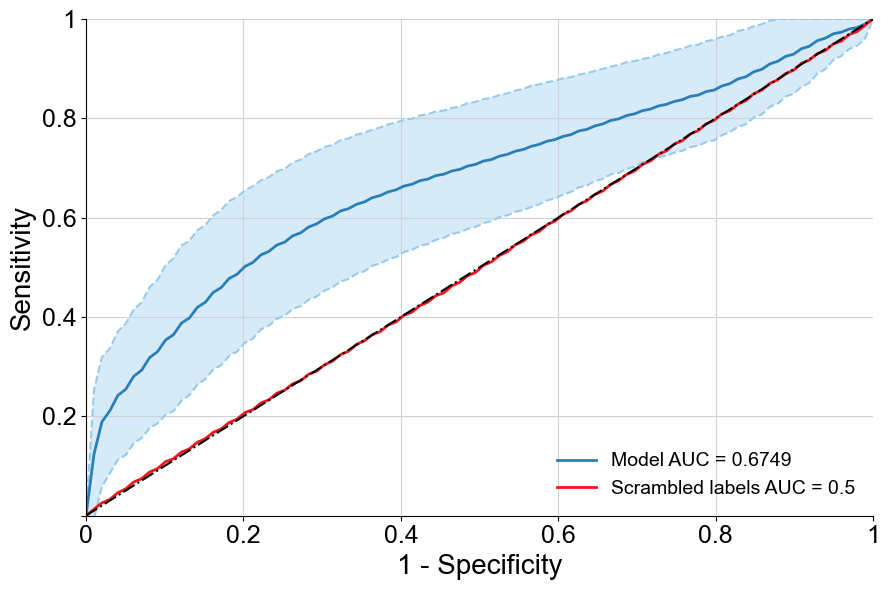

In [26]:
ml_plotting.plot_custom_roc_curve(lr_ROC_AUC, lr_ROC_chance, fname=None)

In [27]:
rf_fimp = bc.permutation_FIMP(data, 'diagnosis', LogisticRegression(), params='default', test_size=.2, n_repeats=n_iter, random_state=123)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [28]:
rf_fimp.sort_values('mean', ascending=False)#.to_csv(path_res+ "/RandomForest/rf_PFI.csv")
top_10p = rf_fimp.sort_values('mean', ascending=False).head(10)

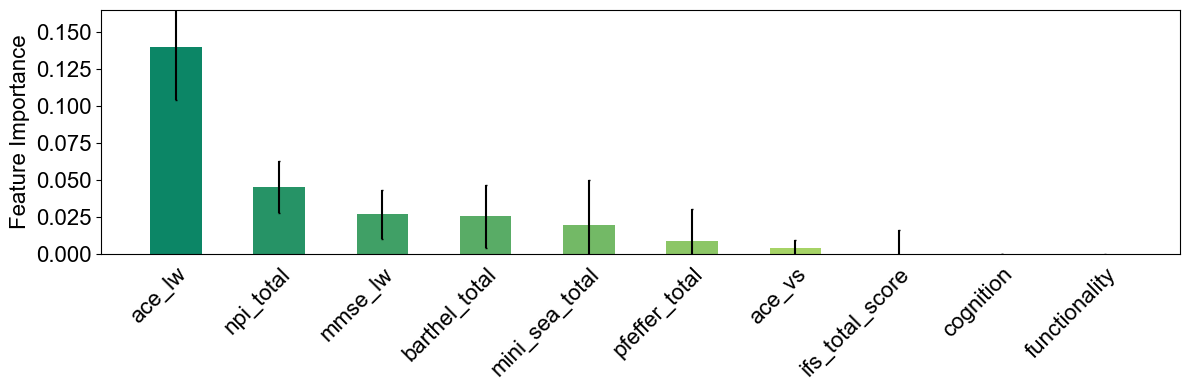

In [29]:
ml_plotting.plot_permutation_FIMP(top_10p, names='predictor', importances_col='mean', std_col='std')

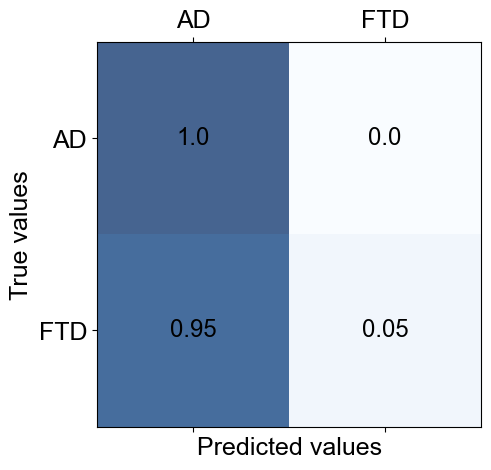

In [30]:
ml_plotting.plot_boostrap_CM(lr_CM, labels=['AD', 'FTD'],fname=None)

#### unseen data

In [31]:
X_train, y_train = data.drop('diagnosis', axis=1), data[['diagnosis']].values.ravel()
X_test, y_test = unseen_data.drop('diagnosis', axis=1), unseen_data[['diagnosis']].values.ravel()

In [32]:
np.linspace(0.1, 1, num=10)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [33]:
# predict & scores
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
roc = np.round(roc_auc_score(y_test, y_pred), 4)
acc = np.round(accuracy_score(y_test, y_pred), 4)
rec = np.round(recall_score(y_test, y_pred),4)
f1 = np.round(f1_score(y_test, y_pred), 4)
prec = np.round(precision_score(y_test, y_pred), 4)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [34]:
unseen_df = pd.DataFrame([roc, acc, rec, f1, prec]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Recall', 'F1', 'Precision']
# unseen_df.to_csv(path_res+ "/RandomForest/unseen.csv")

In [35]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}")

ROC score: 0.5478
Accuracy: 0.7757
Recall: 0.12
F1: 0.2
Precision:0.6


In [36]:
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{lr_res['ROC_AUC'].mean():.4f}")

Unseen Data ROC score: 		0.5478
Bootstrping test ROC score: 	0.6749


### RF Model

##### Bootstrap

In [37]:
Model_res, CI_df, Model_res_r, ROC_AUC, CM, ROC_chance, empirical_p_value = bc.Bootstrap_tree_classifier(
    data, 'diagnosis', RandomForestClassifier(), scaler='MM', params=rf_params, test_size=.2, n_iter=n_iter, chance_model=True)

RandomForestClassifier(class_weight='balanced', max_depth=9, max_features=10,
                       min_samples_leaf=0.01, min_samples_split=0.01,
                       n_estimators=500, n_jobs=-1)


Iterating: 100%|██████████████████| 1000/1000 [42:41<00:00,  2.56s/it]

singular_matrix_errors (droped from results): 0
Eleapsed time:42.69381465911865 minutes
empirical p-value: 0.0


In [38]:
path_res

'/home/marcelo/GitRepos/Tesis/pred_results/2023-11-05/MICE_res'

In [39]:
Model_res.to_csv(path_res+ "/RandomForest_WO/Model_res.csv", index=False)
Model_res.mean()

Accuracy       0.762056
ROC_AUC        0.755574
Precision      0.497945
Recall         0.501630
Sensitivity    0.501630
Specificity    0.842456
F1             0.497812
Efron_pR2      0.066177
dtype: float64

In [40]:
print("%.4f" % Model_res['ROC_AUC'].mean())


0.7556


In [41]:
CI_df.to_csv(path_res+ "/RandomForest_WO/CI_df.csv", index=False)
CI_df

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci,Efron_pR2_ci
0,0.026393,0.026636,0.03099,0.03099,0.03099,0.02258,0.03099,0.015408


In [42]:
Model_res_r.sort_values('Importance_mean', ascending=False).to_csv(path_res+ "/RandomForest_WO/Model_res_r.csv", index=False)
Model_res_r.sort_values('Importance_mean', ascending=False).head(10)

,variables,Importance_mean,Importance_std
6,mini_sea_total,0.196723,0.014444
0,ace_lw,0.117281,0.018174
5,ifs_total_score,0.106508,0.011290
3,cognition,0.090763,0.011158
1,ace_vs,0.086286,0.015150
11,npi_total,0.069029,0.007749
4,functionality,0.055285,0.006002
12,npi_total_caregiver,0.053117,0.004844
7,mmse_lw,0.050579,0.012578
13,pfeffer_total,0.047872,0.004514


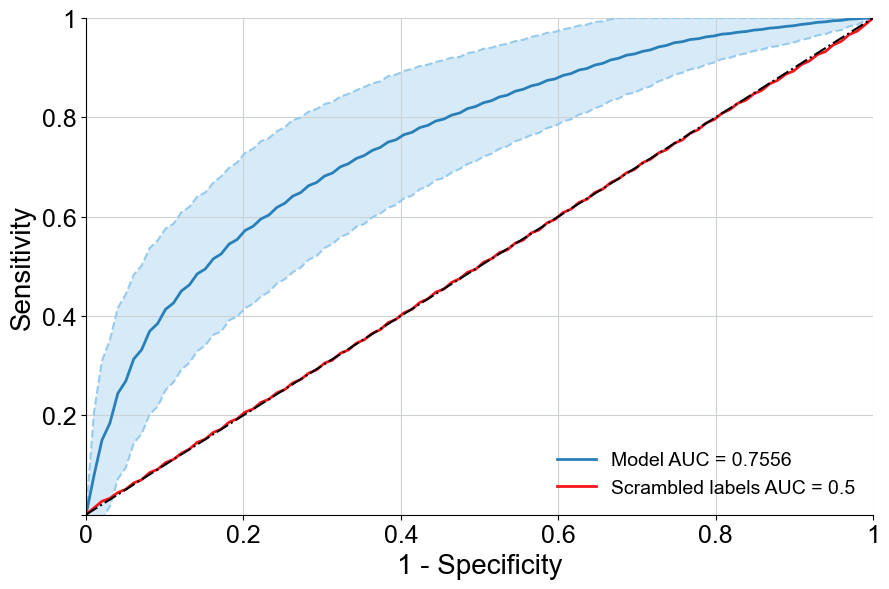

In [43]:
ml_plotting.plot_custom_roc_curve(ROC_AUC, ROC_chance, fname=path_res+ "/RandomForest_WO/ROC_AUC_curve.png")
# Fig save?


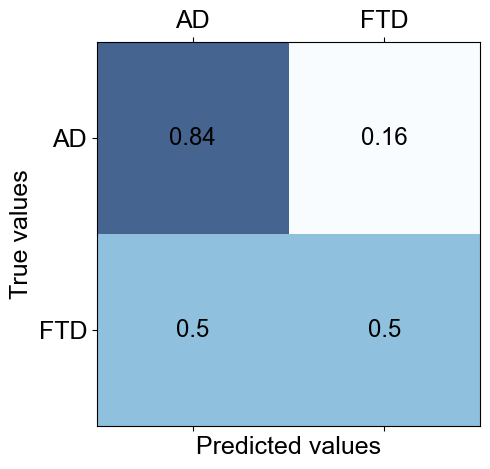

In [44]:
ml_plotting.plot_boostrap_CM(CM, labels=['AD', 'FTD'],fname=path_res+ "/RandomForest_WO/CM.png")

##### Permutation Feature importance

In [45]:
rf_fimp = bc.permutation_FIMP(data, 'diagnosis', RandomForestClassifier(), params=rf_params, test_size=.2, n_repeats=n_iter, random_state=123)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [46]:
rf_fimp.sort_values('mean', ascending=False).to_csv(path_res+ "/RandomForest_WO/rf_PFI.csv")
top_10p = rf_fimp.sort_values('mean', ascending=False).head(10)

In [47]:
top_10p.head()

,predictor,mean,std
1,mini_sea_total,0.066742,0.029650
9,ace_lw,0.050628,0.018884
8,ace_vs,0.023197,0.013480
0,ifs_total_score,0.020490,0.015407
5,mmse_lw,0.014343,0.006116


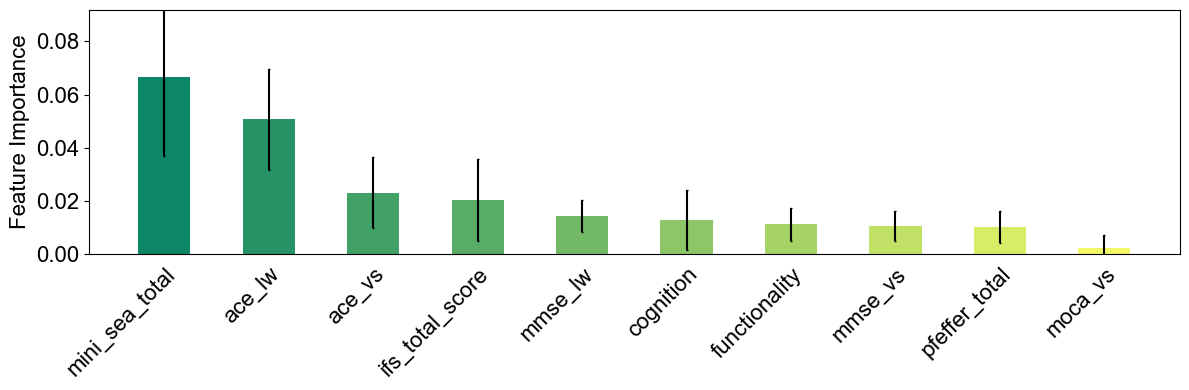

In [48]:
ml_plotting.plot_permutation_FIMP(top_10p, names='predictor', importances_col='mean', std_col='std')

In [49]:
Model_res_r.sort_values('Importance_mean', ascending=False).head()

,variables,Importance_mean,Importance_std
6,mini_sea_total,0.196723,0.014444
0,ace_lw,0.117281,0.018174
5,ifs_total_score,0.106508,0.011290
3,cognition,0.090763,0.011158
1,ace_vs,0.086286,0.015150


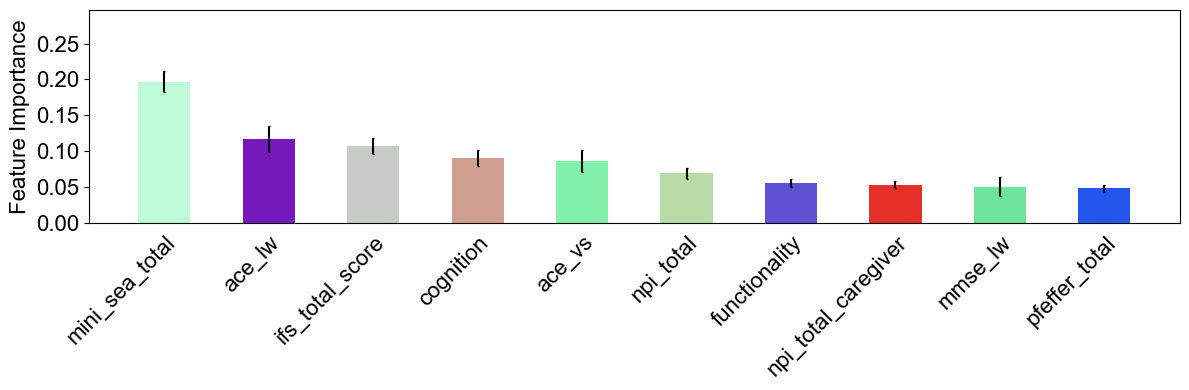

In [50]:
top_10 = Model_res_r.sort_values('Importance_mean', ascending=False).head(10)
ml_plotting.plot_bootstrap_FIMP(top_10, 'variables','Importance_mean', 'Importance_std')

##### unseen data

In [51]:
X_train, y_train = data.drop('diagnosis', axis=1), data[['diagnosis']].values.ravel()
X_test, y_test = unseen_data.drop('diagnosis', axis=1), unseen_data[['diagnosis']].values.ravel()

In [52]:
# predict & scores
rfc = RandomForestClassifier(**rf_params)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
roc = np.round(roc_auc_score(y_test, y_pred), 4)
acc = np.round(accuracy_score(y_test, y_pred), 4)
rec = np.round(recall_score(y_test, y_pred),4)
f1 = np.round(f1_score(y_test, y_pred), 4)
prec = np.round(precision_score(y_test, y_pred), 4)

In [53]:
unseen_df = pd.DataFrame([roc, acc, rec, f1, prec]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Recall', 'F1', 'Precision']
unseen_df.to_csv(path_res+ "/RandomForest_WO/unseen.csv")

In [54]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}")

ROC score: 0.6539
Accuracy: 0.8318
Recall: 0.32
F1: 0.4706
Precision:0.8889


In [55]:
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{Model_res['ROC_AUC'].mean():.4f}")

Unseen Data ROC score: 		0.6539
Bootstrping test ROC score: 	0.7556


#### Shapley

In [56]:
# compute SHAP values
explainer = shap.explainers.Tree(rfc, X_train, feature_names=X_train.columns.tolist(), feature_perturbation="interventional")
shap_values = explainer(X_test, check_additivity=False)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


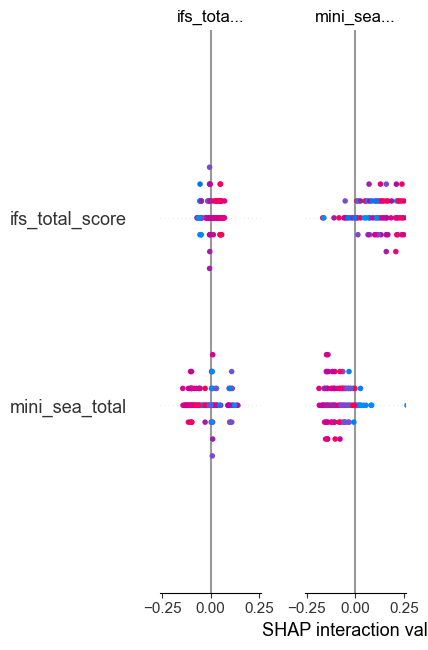

In [57]:
shap.summary_plot(shap_values, feature_names=X_train.columns)

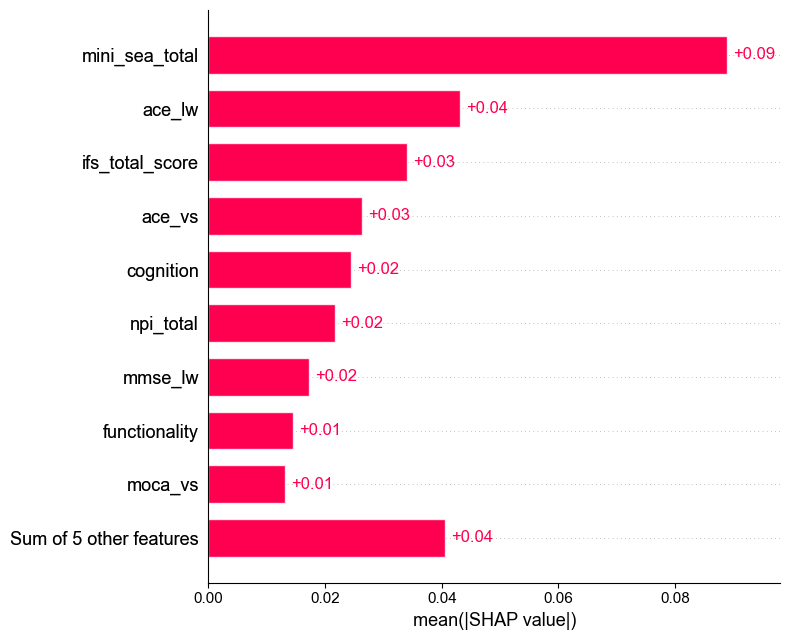

In [58]:
shap.plots.bar(shap_values[:,:,1])

In [59]:
# shap.plots.beeswarm(shap_values[:,:,1])

In [60]:
# # compute SHAP values
# explainer2 = shap.explainers.Tree(rfc, X_train, feature_names=X_train.columns.tolist())
# shap_values2 = explainer(X_test, check_additivity=False)

In [61]:
# shap.summary_plot(shap_values2[:,:,1])

In [62]:
# shap.plots.bar(shap_values2[:,:,1])

In [63]:

# # Convertir shap_values en un DataFrame
# shap_df = pd.DataFrame(shap_values, columns=X_train.columns.tolist())

# # Guardar el DataFrame en un archivo CSV
# shap_df.to_csv('shap_values.csv', index=False)


In [64]:
# shap_values2[:,:,1]

### SVM - Poly

#### Bootstrap

In [65]:
p_Model_res, p_CI_df, p_Model_res_r, p_ROC_AUC, p_CM, p_ROC_chance, p_empirical_p_value = bc.Bootstrap_SVC_classifier(
    data, 'diagnosis', SVC(), params=poly_params, test_size=.2, scaler='MM', n_iter=n_iter, chance_model=True)

SVC(C=8.377922372279789, class_weight='balanced', coef0=0, degree=2,
    gamma=4.437735036441617, kernel='poly', verbose=0)


Iterating: 100%|██████████████████| 1000/1000 [17:45<00:00,  1.07s/it]

singular_matrix_errors (droped from results): 0
Eleapsed time:17.766258215904237 minutes
empirical p-value: 0.001


In [66]:
p_Model_res.to_csv(path_res+ "/SVM_poly_WO/poly_Model_res.csv", index=False)
p_Model_res.mean()

Accuracy       0.734559
ROC_AUC        0.678553
Precision      0.452923
Recall         0.572522
Sensitivity    0.572522
Specificity    0.784584
F1             0.504113
dtype: float64

In [67]:
p_CI_df.to_csv(path_res+ "/SVM_poly_WO/poly_CI_df.csv", index=False)
p_CI_df.mean()

Accuracy_ci       0.027369
ROC_AUC_ci        0.028947
Precision_ci      0.030853
Recall_ci         0.030663
Sensitivity_ci    0.030663
Specificity_ci    0.025481
F1_ci             0.030989
dtype: float64

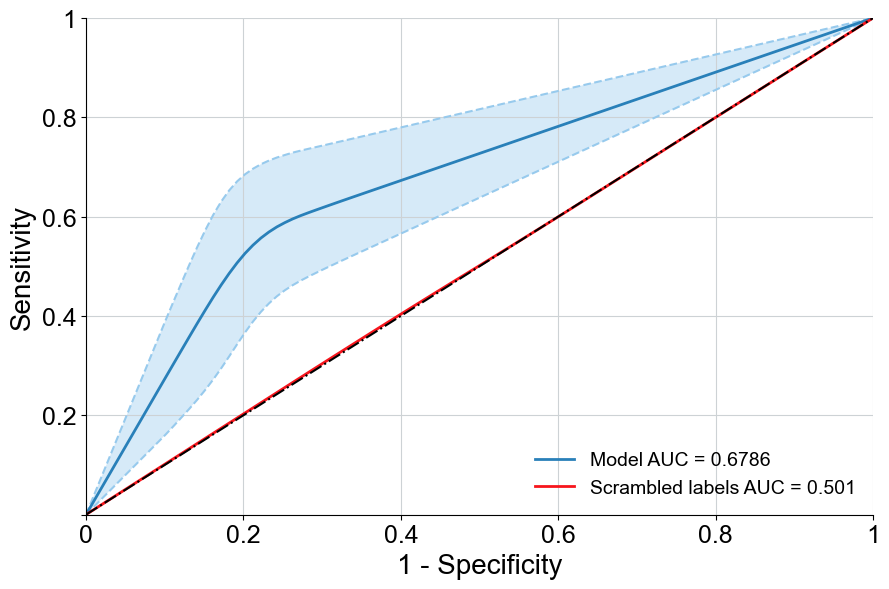

In [68]:
ml_plotting.plot_custom_roc_curve(p_ROC_AUC, p_ROC_chance, fname=path_res+ "/SVM_poly_WO/poly_ROC_AUC_curve.png")

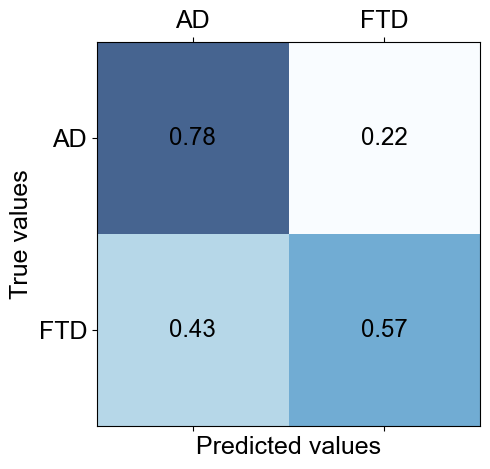

In [69]:
ml_plotting.plot_boostrap_CM(p_CM, labels=['AD', 'FTD'],fname=path_res+ "/SVM_poly_WO/poly_CM.png")

#### Permutation Feature importance

In [70]:
p_fimp = bc.permutation_FIMP( data, 'diagnosis', SVC(), params=poly_params, test_size=.3, n_repeats=n_iter, random_state=123)
p_fimp.sort_values('mean', ascending=False).to_csv(path_res+ "/SVM_poly_WO/poly_PFI.csv")
top_10_poly = p_fimp.sort_values('mean', ascending=False).head(10)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


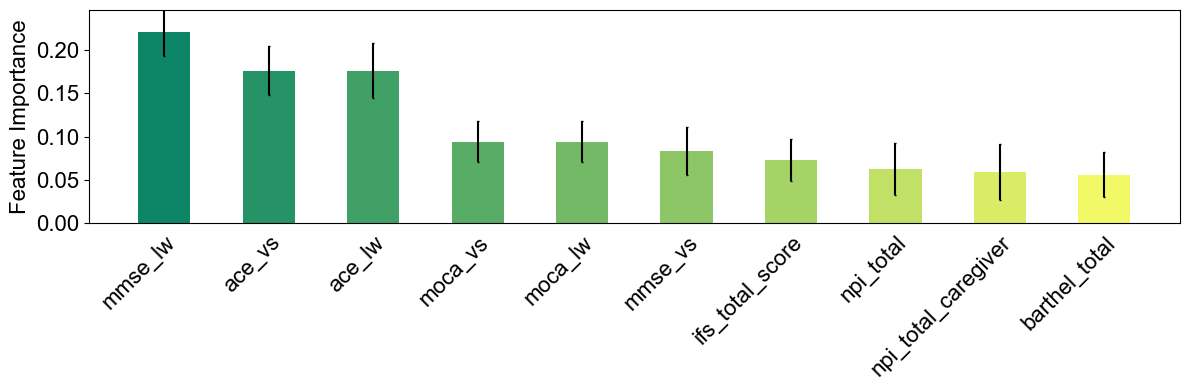

In [71]:
ml_plotting.plot_permutation_FIMP(top_10_poly, names='predictor', importances_col='mean', std_col='std')

#### Unseen data

In [72]:
poly = SVC(**poly_params)
poly=poly.fit(X_train, y_train)
y_pred = poly.predict(X_test)
roc = np.round(roc_auc_score(y_test, y_pred), 4)
acc = np.round(accuracy_score(y_test, y_pred), 4)
rec = np.round(recall_score(y_test, y_pred),4)
f1 = np.round(f1_score(y_test, y_pred), 4)
prec = np.round(precision_score(y_test, y_pred), 4)


In [73]:
unseen_df = pd.DataFrame([roc, acc, rec, f1, prec]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Recall', 'F1', 'Precision']
unseen_df.to_csv(path_res+ "/SVM_poly_WO/poly_PFI.csv")

In [74]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}\n")
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{p_Model_res['ROC_AUC'].mean():.4f}")

ROC score: 0.5317
Accuracy: 0.4953
Recall: 0.6
F1: 0.3571
Precision:0.2542

Unseen Data ROC score: 		0.5317
Bootstrping test ROC score: 	0.6786


#### Shapley

In [75]:
poly_params['probability'] = True

In [76]:
# compute SHAP values
poly = SVC(**poly_params)
poly=poly.fit(X_train, y_train)

masker=shap.maskers.Independent(X_train, max_samples=1)
# explainer = shap.KernelExplainer(model=svc_rbf.predict, data=X_train, masker=masker)
explainer = shap.KernelExplainer(model=poly.predict_proba, data=masker.data)
shap_values = explainer.shap_values(X_train, masker = masker)
# explainer = shap.KernelExplainer(model.predict, X_train_summary, masker=background)

X does not have valid feature names, but SVC was fitted with feature names


  0%|          | 0/974 [00:00<?, ?it/s]

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

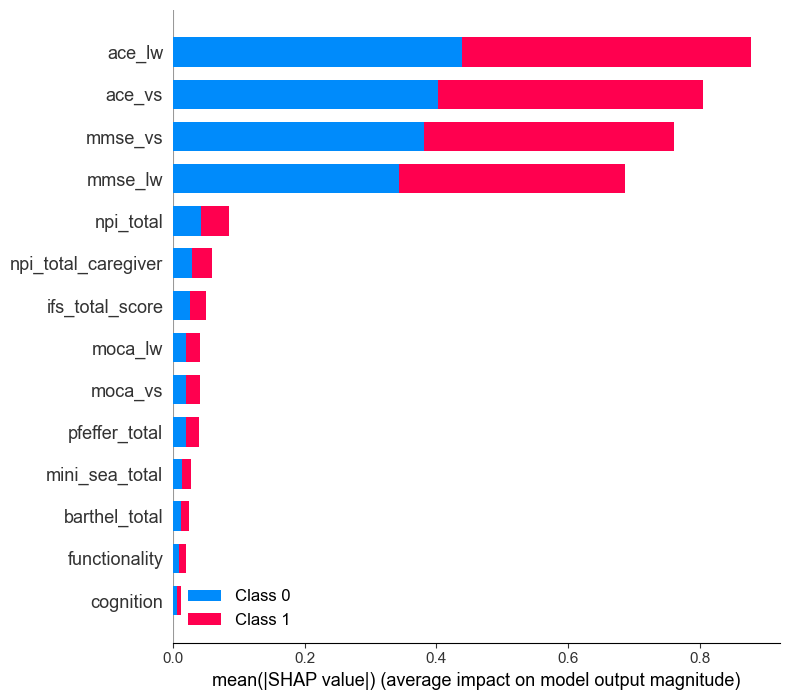

In [77]:
shap.summary_plot(shap_values, feature_names=X_train.columns)
# shap.summary_plot(shap_values[:,:,:1], feature_names=X_train.columns)

### XGBoost

#### Bootstrap

In [78]:
xgb_Model_res, xgb_CI_df, xgb_Model_res_r, xgb_ROC_AUC, xgbCM, xgb_ROC_chance, xgb_empirical_p_value, _ = bc.Bootstrap_XGB_classifier(
    data, 'diagnosis',  params=xgb_params, test_size=.2, scaler='MM', n_iter=n_iter, chance_model=True)

Iterating: 100%|██████████████████| 1000/1000 [33:22<00:00,  2.00s/it]

singular_matrix_errors (droped from results): 0
Eleapsed time:33.37847683827082 minutes
empirical p-value: 0.0


In [79]:
xgb_Model_res.to_csv(path_res+ "/XGBoost_WO/xgb_Model_res.csv", index=False)
xgb_Model_res.mean()

Accuracy       0.775769
ROC_AUC        0.734709
Precision      0.552615
Recall         0.288717
Sensitivity    0.288717
Specificity    0.926134
F1             0.375727
Efron_pR2      0.115568
dtype: float64

In [80]:
xgb_Model_res_r.sort_values('Importance_gain_mean', ascending=False).to_csv(path_res+"/XGBoost_WO/xgb_Model_res_r.csv", index=False)
xgb_Model_res_r.sort_values('Importance_f_score_mean', ascending=False).head(10)

,variables,Importance_f_score_mean,Importance_f_score_std,Importance_gain_mean,Importance_gain_std
6,mini_sea_total,60.535,10.341166,1.534229,0.248325
5,ifs_total_score,54.375,10.778616,1.013506,0.191029
10,npi_total,47.980,9.566458,0.847248,0.151271
11,npi_total_caregiver,40.626,9.078686,0.731192,0.168173
9,moca_vs,35.901,7.930958,1.081689,0.252831
12,pfeffer_total,35.875,9.401051,0.973916,0.223487
2,barthel_total,30.596,7.015269,0.918137,0.198995
1,ace_vs,30.239,7.338101,1.119038,0.281613
8,mmse_vs,28.261,7.983647,1.810956,0.510753
4,functionality,20.632,6.432103,0.967104,0.299514


In [81]:
xgb_CI_df.to_csv(path_res+ "/XGBoost_WO/xgb_CI_df.csv", index=False)
xgb_CI_df

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci,Efron_pR2_ci
0,0.025851,0.027364,0.030818,0.028088,0.028088,0.016211,0.030018,0.019816


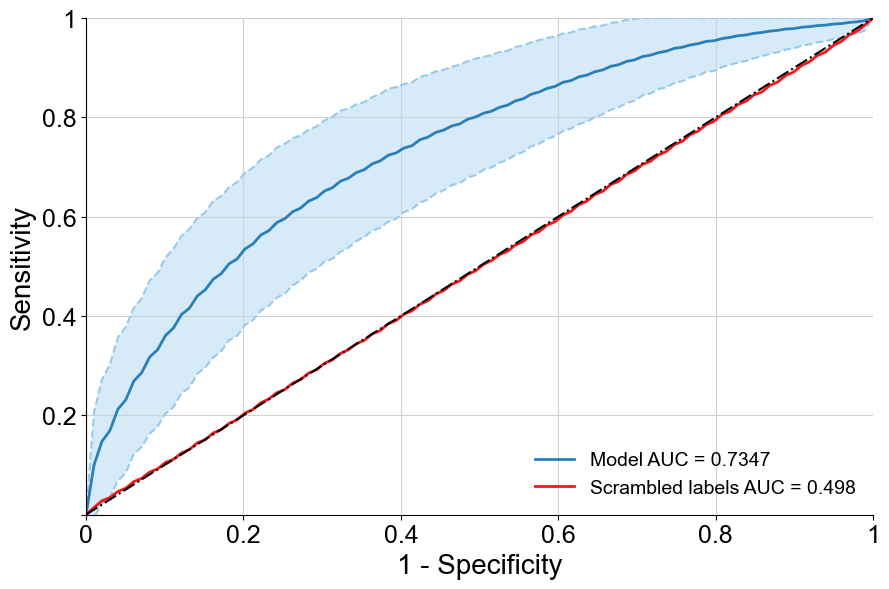

In [82]:
ml_plotting.plot_custom_roc_curve(xgb_ROC_AUC, xgb_ROC_chance, fname=path_res+ "/XGBoost_WO/xgb_ROC.png")

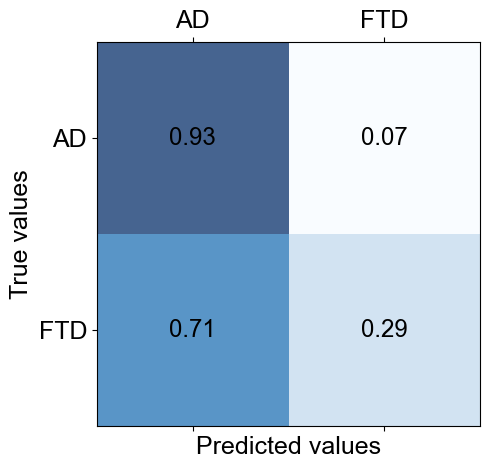

In [83]:
ml_plotting.plot_boostrap_CM(xgbCM, labels=['AD', 'FTD'],fname=path_res+ "/XGBoost_WO/xgb_CM.png")

#### Permutation Feature importance

In [84]:
xgb_fimp = bc.permutation_FIMP( data, 'diagnosis', xgboost.XGBClassifier(), params=xgb_params, test_size=.3, n_repeats=1000, random_state=123)
xgb_fimp.sort_values('mean', ascending=False).to_csv(path_res+ "/XGBoost_WO/xgb_PFI.csv")
top_10_xgb=xgb_fimp.sort_values('mean', ascending=False).head(10)

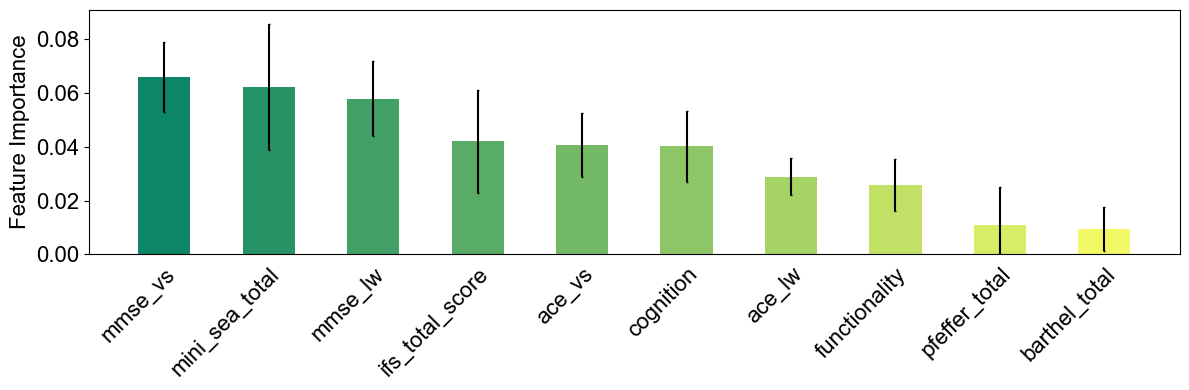

In [85]:
ml_plotting.plot_permutation_FIMP(top_10_xgb, names='predictor', importances_col='mean', std_col='std')

In [86]:
xgb_Model_res_r

,variables,Importance_f_score_mean,Importance_f_score_std,Importance_gain_mean,Importance_gain_std
0,ace_lw,8.771772,3.991971,2.173644,0.931937
1,ace_vs,30.239000,7.338101,1.119038,0.281613
2,barthel_total,30.596000,7.015269,0.918137,0.198995
3,cognition,17.477000,6.271747,0.919095,0.336489
4,functionality,20.632000,6.432103,0.967104,0.299514
5,ifs_total_score,54.375000,10.778616,1.013506,0.191029
6,mini_sea_total,60.535000,10.341166,1.534229,0.248325
7,mmse_lw,12.109109,4.929677,5.765825,2.490132
8,mmse_vs,28.261000,7.983647,1.810956,0.510753
9,moca_vs,35.901000,7.930958,1.081689,0.252831


In [87]:
top_10_xgb = xgb_Model_res_r.sort_values('Importance_f_score_mean', ascending=False).head(10)
top_10_xgb

,variables,Importance_f_score_mean,Importance_f_score_std,Importance_gain_mean,Importance_gain_std
6,mini_sea_total,60.535,10.341166,1.534229,0.248325
5,ifs_total_score,54.375,10.778616,1.013506,0.191029
10,npi_total,47.980,9.566458,0.847248,0.151271
11,npi_total_caregiver,40.626,9.078686,0.731192,0.168173
9,moca_vs,35.901,7.930958,1.081689,0.252831
12,pfeffer_total,35.875,9.401051,0.973916,0.223487
2,barthel_total,30.596,7.015269,0.918137,0.198995
1,ace_vs,30.239,7.338101,1.119038,0.281613
8,mmse_vs,28.261,7.983647,1.810956,0.510753
4,functionality,20.632,6.432103,0.967104,0.299514


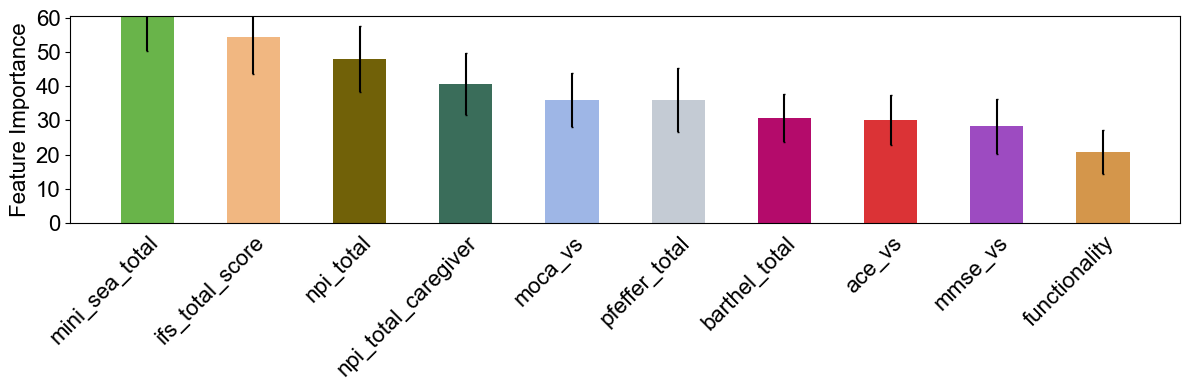

In [88]:
ml_plotting.plot_bootstrap_FIMP(top_10_xgb, 'variables','Importance_f_score_mean', 'Importance_f_score_std')

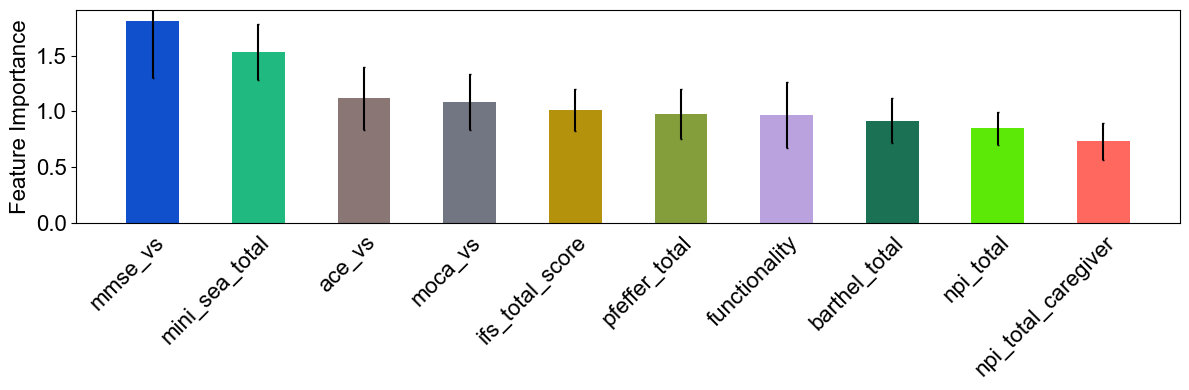

In [89]:
ml_plotting.plot_bootstrap_FIMP(top_10_xgb, 'variables','Importance_gain_mean', 'Importance_gain_std')

#### Unseen data

In [90]:
xgb = xgboost.XGBClassifier(**xgb_params)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
roc = np.round(roc_auc_score(y_test, y_pred), 4)
acc = np.round(accuracy_score(y_test, y_pred), 4)
rec = np.round(recall_score(y_test, y_pred),4)
f1 = np.round(f1_score(y_test, y_pred), 4)
prec = np.round(precision_score(y_test, y_pred), 4)


In [91]:
unseen_df = pd.DataFrame([roc, acc, rec, f1, prec]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Recall', 'F1', 'Precision']
unseen_df.to_csv(path_res+ "/XGBoost_WO/xgb_PFI.csv")

In [92]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}\n")
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{xgb_Model_res['ROC_AUC'].mean():.4f}")

ROC score: 0.6
Accuracy: 0.8131
Recall: 0.2
F1: 0.3333
Precision:1.0

Unseen Data ROC score: 		0.6
Bootstrping test ROC score: 	0.7347


#### Shapley

In [93]:
# # compute SHAP values
# explainer = shap.explainers.Tree(xgb, X_train, feature_names=X_train.columns.tolist())
# shap_values = explainer(X_train, check_additivity=False)

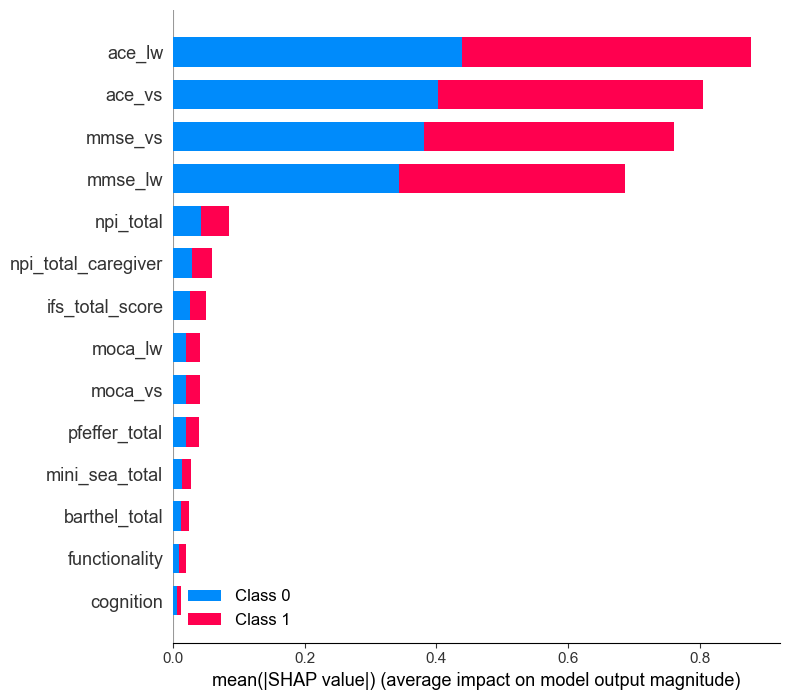

In [94]:
shap.summary_plot(shap_values, feature_names=X_train.columns)

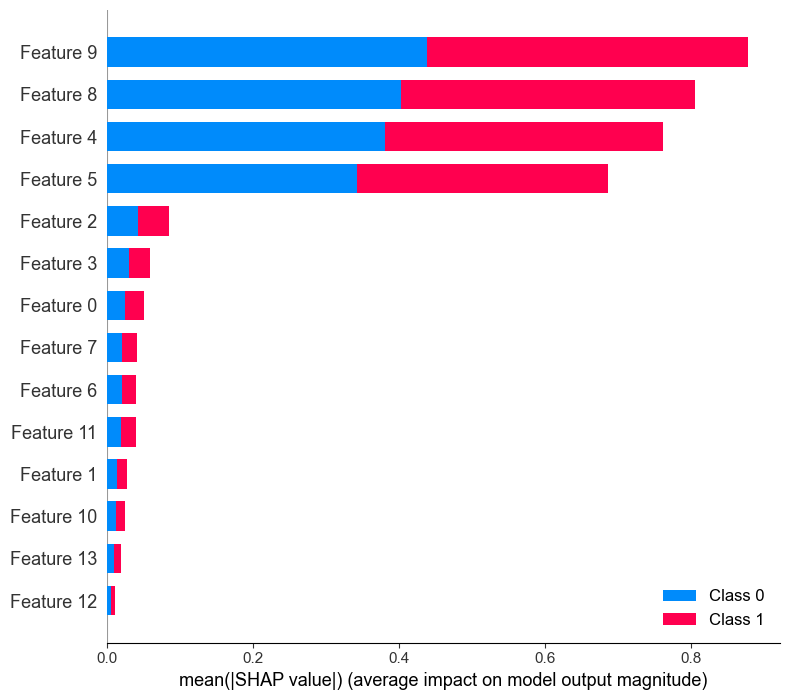

In [95]:
shap.summary_plot(shap_values)

In [96]:
#shap.plots.bar(shap_values)

### Sequential feature selector

#### RF

In [97]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [98]:
n_splits = 3
cv = StratifiedKFold(n_splits=n_splits)

In [99]:
rf_params

{'n_estimators': 500,
 'criterion': 'gini',
 'max_depth': 9,
 'min_samples_split': 0.01,
 'min_samples_leaf': 0.01,
 'max_features': 10,
 'class_weight': 'balanced',
 'verbose': 0,
 'n_jobs': -1}

In [100]:
sfs_rfc = SFS(RandomForestClassifier(class_weight= 'balanced'), 
           k_features=len(X_train.columns), 
           forward=True, 
           floating=False, 
           verbose=1,
           cv=cv, n_jobs =-1)

In [101]:
sfs_rfc = sfs_rfc.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.7s finished
Features: 1/14[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  13 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.6s finished
Features: 2/14[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.6s finished
Features: 3/14[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:    0.5s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.6s finished
Features: 4/14[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 

In [102]:
pd.DataFrame.from_dict(sfs_rfc.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(12,)","[0.7015384615384616, 0.7138461538461538, 0.734...",0.716651,"(cognition,)",0.03067,0.013629,0.009637
2,"(1, 12)","[0.7507692307692307, 0.7723076923076924, 0.771...",0.764894,"(mini_sea_total, cognition)",0.022485,0.009992,0.007065
3,"(1, 7, 12)","[0.7753846153846153, 0.7784615384615384, 0.780...",0.778237,"(mini_sea_total, moca_lw, cognition)",0.005047,0.002243,0.001586
4,"(1, 2, 7, 12)","[0.7753846153846153, 0.7907692307692308, 0.796...",0.787483,"(mini_sea_total, npi_total, moca_lw, cognition)",0.01991,0.008848,0.006256
5,"(1, 2, 7, 12, 13)","[0.7907692307692308, 0.7907692307692308, 0.808...",0.796727,"(mini_sea_total, npi_total, moca_lw, cognition...",0.01896,0.008425,0.005958
6,"(1, 2, 5, 7, 12, 13)","[0.7938461538461539, 0.7938461538461539, 0.805...",0.797749,"(mini_sea_total, npi_total, mmse_lw, moca_lw, ...",0.012422,0.00552,0.003903
7,"(1, 2, 5, 6, 7, 12, 13)","[0.803076923076923, 0.796923076923077, 0.79938...",0.799794,"(mini_sea_total, npi_total, mmse_lw, moca_vs, ...",0.005691,0.002529,0.001788
8,"(0, 1, 2, 5, 6, 7, 12, 13)","[0.8061538461538461, 0.7938461538461539, 0.805...",0.801852,"(ifs_total_score, mini_sea_total, npi_total, m...",0.012751,0.005666,0.004007
9,"(0, 1, 2, 5, 6, 7, 11, 12, 13)","[0.8061538461538461, 0.796923076923077, 0.7993...",0.80082,"(ifs_total_score, mini_sea_total, npi_total, m...",0.008783,0.003903,0.00276
10,"(0, 1, 2, 5, 6, 7, 8, 11, 12, 13)","[0.796923076923077, 0.7938461538461539, 0.8024...",0.797746,"(ifs_total_score, mini_sea_total, npi_total, m...",0.008029,0.003568,0.002523


In [103]:
from sklearn.feature_selection import SequentialFeatureSelector as ssfs
from sklearn.feature_selection import RFECV

In [104]:
rfecv_rf = RFECV(RandomForestClassifier(class_weight= 'balanced'), step=1, min_features_to_select=5, cv=cv, scoring='roc_auc', verbose=1,
      n_jobs=-1, importance_getter='auto')

In [105]:
rfecv_rf=rfecv_rf.fit(X_train, y_train)

Fitting estimator with 14 features.


In [106]:
X_train.columns[rfecv_rf.support_]

Index(['ifs_total_score', 'mini_sea_total', 'npi_total', 'npi_total_caregiver',
       'mmse_vs', 'mmse_lw', 'moca_vs', 'moca_lw', 'ace_vs', 'ace_lw',
       'pfeffer_total', 'cognition', 'functionality'],
      dtype='object')

### XBoost

In [107]:
sfs_xgb = SFS(xgboost.XGBClassifier(), 
           k_features=len(X_train.columns), 
           forward=True, 
           floating=False, 
           verbose=1,
           cv=cv, n_jobs =-1)

In [108]:
sfs_xgb = sfs_xgb.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.2s finished
Features: 1/14[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  13 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.1s finished
Features: 2/14[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.2s finished
Features: 3/14[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.2s finished
Features: 4/14[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 

In [109]:
pd.DataFrame.from_dict(sfs_xgb.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(4,)","[0.7815384615384615, 0.76, 0.7839506172839507]",0.775163,"(mmse_vs,)",0.024229,0.010767,0.007613
2,"(1, 4)","[0.7661538461538462, 0.796923076923077, 0.7993...",0.787487,"(mini_sea_total, mmse_vs)",0.03402,0.015118,0.01069
3,"(1, 4, 12)","[0.7692307692307693, 0.7938461538461539, 0.790...",0.7844,"(mini_sea_total, mmse_vs, cognition)",0.024379,0.010833,0.00766
4,"(1, 4, 10, 12)","[0.7507692307692307, 0.8123076923076923, 0.799...",0.787487,"(mini_sea_total, mmse_vs, barthel_total, cogni...",0.05962,0.026494,0.018734
5,"(1, 4, 6, 10, 12)","[0.7723076923076924, 0.796923076923077, 0.8148...",0.794682,"(mini_sea_total, mmse_vs, moca_vs, barthel_tot...",0.039214,0.017426,0.012322
6,"(1, 4, 6, 7, 10, 12)","[0.7723076923076924, 0.796923076923077, 0.8148...",0.794682,"(mini_sea_total, mmse_vs, moca_vs, moca_lw, ba...",0.039214,0.017426,0.012322
7,"(1, 4, 6, 7, 10, 11, 12)","[0.7846153846153846, 0.7938461538461539, 0.805...",0.794672,"(mini_sea_total, mmse_vs, moca_vs, moca_lw, ba...",0.019282,0.008569,0.006059
8,"(1, 2, 4, 6, 7, 10, 11, 12)","[0.7723076923076924, 0.803076923076923, 0.7962...",0.79056,"(mini_sea_total, npi_total, mmse_vs, moca_vs, ...",0.029704,0.0132,0.009334
9,"(0, 1, 2, 4, 6, 7, 10, 11, 12)","[0.7907692307692308, 0.7938461538461539, 0.793...",0.792608,"(ifs_total_score, mini_sea_total, npi_total, m...",0.002984,0.001326,0.000938
10,"(0, 1, 2, 4, 5, 6, 7, 10, 11, 12)","[0.796923076923077, 0.7907692307692308, 0.7870...",0.791576,"(ifs_total_score, mini_sea_total, npi_total, m...",0.009173,0.004076,0.002882


In [110]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

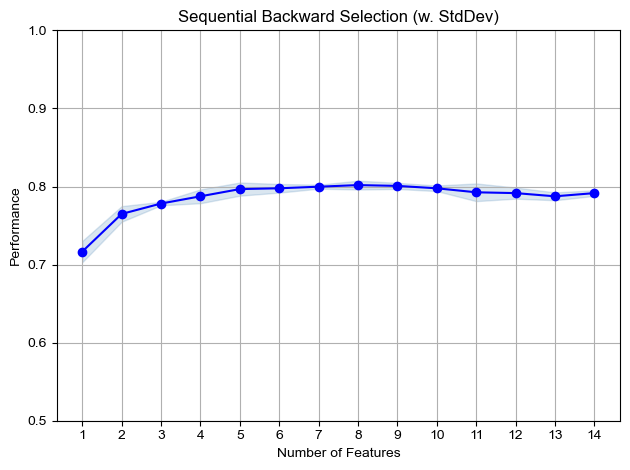

In [111]:
fig1 = plot_sfs(sfs_rfc.get_metric_dict(), kind='std_dev')


plt.ylim([0.5, 1])
# plt.figure(figsize=(13, 3))
plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.show()

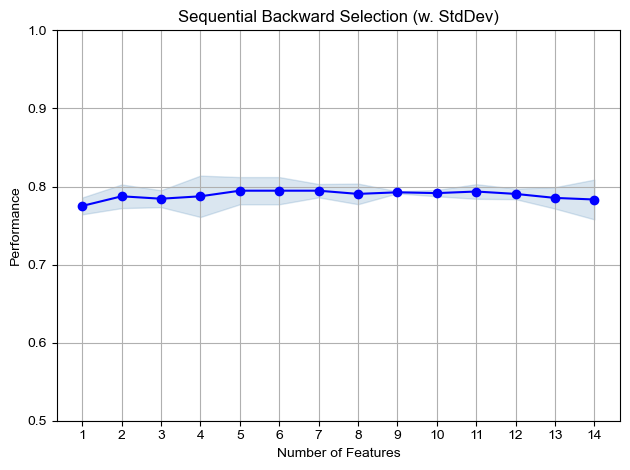

Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.


In [112]:
fig2 = plot_sfs(sfs_xgb.get_metric_dict(), kind='std_dev')


plt.ylim([0.5, 1])
# plt.figure(figsize=(13, 3))
plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.show()